In [1]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
pacs = pd.read_csv('Campaign_Finance_data/pacs_all.csv', encoding = "ISO-8859-1")
conginvest = pd.read_csv('Goal1_PFD_1of3.csv', encoding = "ISO-8859-1")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cmte = pd.read_csv('Campaign_Finance_data/cmtes_all.csv', encoding = "ISO-8859-1")
pacs = pacs.merge(cmte[['CmteID', 'PACShort']], left_on='PACID', right_on='CmteID', how='left').drop('CmteID', axis=1)

temp = pacs[['Cycle','PACID','PACShort']].drop_duplicates()

print('Number of PACIDs with multiple organization names: ',
    len(temp.groupby(['Cycle','PACID'])['PACShort'].size().reset_index(). \
        query('PACShort > 1'))) #16723 

del temp, cmte

Number of PACIDs with multiple organization names:  16723


In [4]:
# RealCodeOut is congresspeople investing
# RealCodeIn is industry giving money to congresspeople
conginvest = conginvest[['CID', 'RealCode']].rename(columns={'RealCode':'RealCodeOut'}). \
    groupby(['CID','RealCodeOut']).size().reset_index(name='NumInvestments')
pacs = pacs[['Cycle', 'CID', 'PACID', 'Amount', 'RealCode']].rename(columns={'RealCode':'RealCodeIn'})

In [5]:
contributions = pacs. \
    groupby(['PACID', 'RealCodeIn', 'CID'])['Amount']. \
    sum().reset_index()

print(len(contributions))
contributions.head()

920282


,PACID,RealCodeIn,CID,Amount
0,C00000026,H1500,N00000209,2500
1,C00000026,H1500,N00000659,5000
2,C00000026,H1500,N00000756,42630
3,C00000026,H1500,N00000817,2500
4,C00000026,H1500,N00001022,500


In [6]:
df = contributions.merge(conginvest, 
                         left_on=['CID','RealCodeIn'], right_on=['CID','RealCodeOut'], how='left'). \
                        drop('RealCodeOut', axis=1). \
                        rename(columns={'RealCodeIn': 'RealCode'})
df.dropna().head()

,PACID,RealCode,CID,Amount,NumInvestments
78,C00000042,M2300,N00000561,162500,19.0
87,C00000042,M2300,N00001489,45500,1.0
99,C00000042,M2300,N00002097,13000,4.0
103,C00000042,M2300,N00002315,52000,10.0
105,C00000042,M2300,N00002328,26000,5.0


In [7]:
industry_df = df.groupby(['RealCode', 'CID'])['Amount', 'NumInvestments']. \
    sum().reset_index()

industry_df.dropna().head()

,RealCode,CID,Amount,NumInvestments
21,A0000,N00004645,6000,3.0
29,A0000,N00005559,31000,6.0
31,A0000,N00006263,12000,2.0
108,A1000,N00001329,52000,1.0
113,A1000,N00001510,91000,9.0


In [8]:
industry_subset = pd.DataFrame(industry_df.dropna()[:30])

G = nx.from_pandas_dataframe(industry_subset, 'RealCode', 'CID', ['Amount', 'NumInvestments'])
#nx.write_graphml(G, 'investmentlinks.graphml')

In [9]:
node_size = industry_df.groupby('RealCode')['Amount'].sum().to_dict()
nx.set_node_attributes(G, node_size, 'size')

nx.get_node_attributes(G, 'size')

{'A0000': 1541587, 'A1000': 24570695}

In [10]:
G['A0000']['N00005559']

{'Amount': 31000, 'NumInvestments': 6.0}

In [15]:
nx.get_edge_attributes(G,'NumInvestments')

{('A0000', 'N00004645'): 3.0,
 ('A0000', 'N00005559'): 6.0,
 ('A0000', 'N00006263'): 2.0,
 ('A1000', 'N00001329'): 1.0,
 ('A1000', 'N00001510'): 9.0,
 ('A1000', 'N00001758'): 98.0,
 ('A1000', 'N00002091'): 3.0,
 ('A1000', 'N00002269'): 6.0,
 ('A1000', 'N00002315'): 12.0,
 ('A1000', 'N00002383'): 3.0,
 ('A1000', 'N00002743'): 36.0,
 ('A1000', 'N00002877'): 8.0,
 ('A1000', 'N00003028'): 16.0,
 ('A1000', 'N00003062'): 6.0,
 ('A1000', 'N00003254'): 19.0,
 ('A1000', 'N00003288'): 1.0,
 ('A1000', 'N00003675'): 3.0,
 ('A1000', 'N00003682'): 6.0,
 ('A1000', 'N00003709'): 262.0,
 ('A1000', 'N00004208'): 2.0,
 ('A1000', 'N00004227'): 46.0,
 ('A1000', 'N00004436'): 10.0,
 ('A1000', 'N00004484'): 8.0,
 ('A1000', 'N00004558'): 16.0,
 ('A1000', 'N00004698'): 1.0,
 ('A1000', 'N00004781'): 6.0,
 ('A1000', 'N00004905'): 9.0,
 ('A1000', 'N00005165'): 2.0,
 ('A1000', 'N00005178'): 2.0,
 ('N00004645', 'A1000'): 11.0}

In [14]:
pos = nx.spring_layout(G, scale=10, weight='Amount', k=10)
plt.figure(figsize=(30,30))
nx.draw_networkx(G, pos)

#nx.draw_networkx_nodes(G, pos, node_size=[4800,10,10,10,19100,10,10,10,10,10,10,10])
nx.draw_networkx_labels(G, pos, font_size=2)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]

nx.draw_networkx_edges(G, pos, edge_color = 'NumInvestments')
edge_labels = nx.get_edge_attributes(G,'NumInvestments')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size=12)
    #, label_pos=0.5)

plt.savefig('graph.pdf', dpi=800)
# the closer the node, the greater the amount the industry has contributed to that congressperson

{('A0000', 'N00004645'): Text(-4.74945,4.63014,'3.0'),
 ('A0000', 'N00005559'): Text(-8.00874,6.83406,'6.0'),
 ('A0000', 'N00006263'): Text(-6.37377,8.56561,'2.0'),
 ('A1000', 'N00001329'): Text(1.99999,-0.328336,'1.0'),
 ('A1000', 'N00001510'): Text(-0.271626,-0.0358058,'9.0'),
 ('A1000', 'N00001758'): Text(0.00151301,-1.24046,'98.0'),
 ('A1000', 'N00002091'): Text(-0.86709,-0.664107,'3.0'),
 ('A1000', 'N00002269'): Text(1.45655,0.22897,'6.0'),
 ('A1000', 'N00002315'): Text(0.275765,-1.68849,'12.0'),
 ('A1000', 'N00002383'): Text(2.66348,-2.44521,'3.0'),
 ('A1000', 'N00002743'): Text(0.79234,-1.2628,'36.0'),
 ('A1000', 'N00002877'): Text(0.923256,0.851069,'8.0'),
 ('A1000', 'N00003028'): Text(2.2751,-1.0724,'16.0'),
 ('A1000', 'N00003062'): Text(0.843894,-3.32303,'6.0'),
 ('A1000', 'N00003254'): Text(-1.2055,-3.61624,'19.0'),
 ('A1000', 'N00003288'): Text(1.59356,-1.56595,'1.0'),
 ('A1000', 'N00003675'): Text(0.278665,-0.613571,'3.0'),
 ('A1000', 'N00003682'): Text(0.91054,-1.98027,'6

TypeError: iteration over a 0-d array

In [53]:
#nx.write_gpickle(G,"test.gpickle")

AttributeError: 'NoneType' object has no attribute 'show'

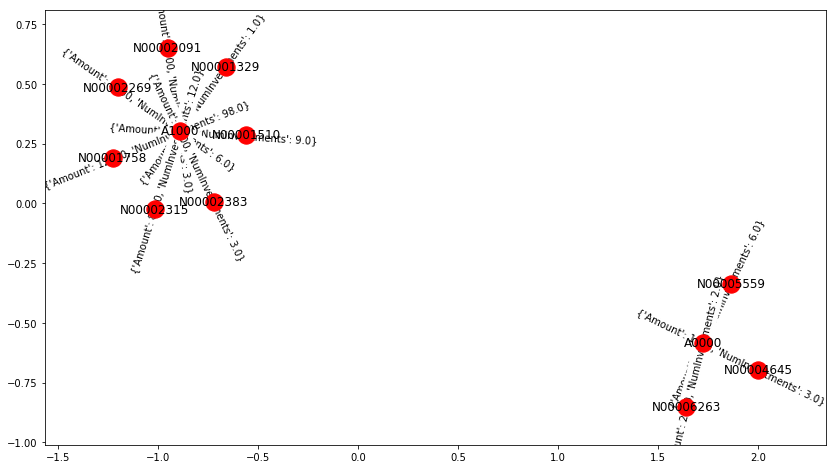

In [125]:
pos = nx.spring_layout(D, scale=2)
nx.draw_networkx(sD, pos, size='size')

nx.draw_networkx_edge_labels(D, pos)

plt.figure(figsize=(12,12), dpi=80)
plt.savefig('graph.pdf')